### This notebook demonstrates the ability of the DisparateImpactRemover algorithm.
The algorithm corrects for imbalanced selection rates between unprivileged and privileged groups at various levels of repair. It follows the guidelines set forth by [1] for training the algorithm and classifier and uses the AdultDataset as an example.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from matplotlib import pyplot as plt

import sys
sys.path.append("../")
import warnings

import numpy as np
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import MinMaxScaler

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric

In [2]:
protected = 'sex'
ad = AdultDataset(protected_attribute_names=[protected],
    privileged_classes=[['Male']], categorical_features=[],
    features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'])

In [3]:
scaler = MinMaxScaler(copy=False)

In [4]:
test, train = ad.split([16281])
train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)

index = train.feature_names.index(protected)

In [5]:
DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(train)
    test_repd = di.fit_transform(test)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    p = [{protected: 1}]
    u = [{protected: 0}]
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
    DIs.append(cm.disparate_impact())

100%|██████████| 11/11 [00:30<00:00,  2.16s/it]


<IPython.core.display.Javascript object>


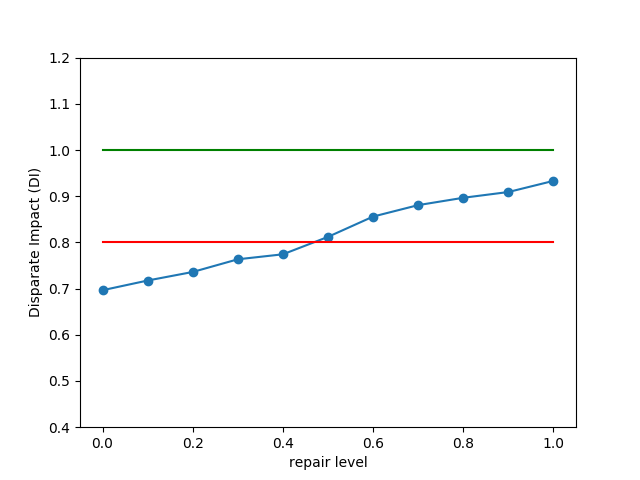

In [6]:
%matplotlib notebook

plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

    References:
        .. [1] M. Feldman, S. A. Friedler, J. Moeller, C. Scheidegger, and
           S. Venkatasubramanian, "Certifying and removing disparate impact."
           ACM SIGKDD International Conference on Knowledge Discovery and Data
           Mining, 2015.